In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from autoencoder import AutoEncoder, VariationalAutoEncoder, RMS
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import PurePosixPath as Path

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in RMS data for tests

In [46]:
exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
# exps = ['Test 9']
rms = {}

for test in exps:
    rms[test] = RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass


Loaded Test 5 RMS Data

Loaded Test 7 RMS Data

Loaded Test 8 RMS Data

Loaded Test 9 RMS Data


# Setup Variational Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [47]:
autoe = {}
for test in exps:
        # autoe[test] = VariationalAutoEncoder(rms[test],
        #                                    tb=False,
        #                                    tb_logdir=rms[test].exp_name,
        #                                    train_slice=(0, 50),
        #                                    random_state=1,
        #                                    params={'latent_dim': 2,
        #                                            'n_size': [32, 16],
        #                                            'epochs': 300,
        #                                            'batch_size': 20,
        #                                            'callbacks': [
        #                                                    tf.keras.callbacks.EarlyStopping(
        #                                                         monitor='val_loss',
        #                                                         patience=30,
        #                                                         mode='min',
        #                                                         start_from_epoch=100,
        #                                                    ),
        #                                                 ]
        #                                            }
        #                                    )
        autoe[test] = AutoEncoder(rms[test],
                                  tb=False,
                                  tb_logdir=rms[test].exp_name,
                                  train_slice=(0, 65),
                                  val_frac=0.1,
                                  random_state=2,
                                  params={'n_bottleneck': 5,
                                          'n_size': [32,32],
                                          'epochs': 750,
                                          'batch_size': 40,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=40,
                                                              mode='min',
                                                              start_from_epoch= 200,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )       

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 407)
	Input val shape: (7, 407)

AUTOE-TEST_5-E-750-L-[32, 32, 5, 32, 32]-20230522-115418

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 410)
	Input val shape: (7, 410)

AUTOE-TEST_7-E-750-L-[32, 32, 5, 32, 32]-20230522-115418

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 393)
	Input val shape: (7, 393)

AUTOE-TEST_8-E-750-L-[32, 32, 5, 32, 32]-20230522-115418

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 394)
	Input val shape: (7, 394)

AUTOE-TEST_9-E-750-L-[32, 32, 5, 32, 32]-20230522-115418



In [48]:
platform = os.name
if platform == 'nt':
    onedrive = Path(r'C:\Users\tomje\OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    ML_DIR = onedrive.joinpath('Tensorboard')
elif platform == 'posix':
    onedrive = Path(r'/mnt/c/Users/tomje/OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    ML_DIR = onedrive.joinpath('Tensorboard')
print(ML_DIR)

C:\Users\tomje\OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [49]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=ML_DIR.joinpath('models', rms[test].exp_name, f'{name}_best.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [50]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                      val_data=autoe[test].val_data,
                      verbose=0,
                      use_multiprocessing=True,
                      )

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

## Reload saved weights from best model

In [53]:
for test in exps:
    name = autoe[test].run_name
    autoe[test].model.model_.load_weights(ML_DIR.joinpath('models', rms[test].exp_name, f'{name}_best.h5'))
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

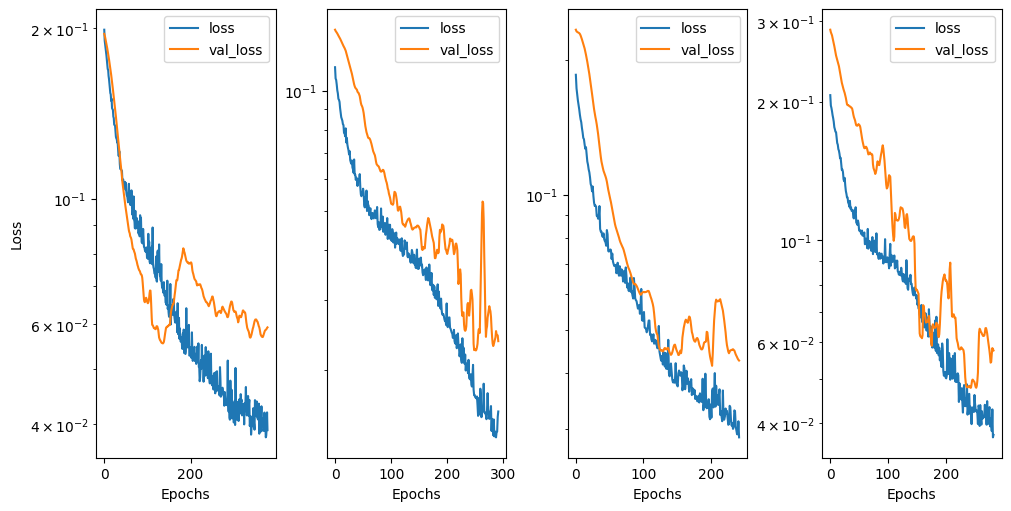

In [54]:
fig, ax = plt.subplots(1, len(exps), figsize=(10,5), constrained_layout=True)
# ax = ax.ravel()
for i, test in enumerate(exps):
    axis = fig.axes[i]
    autoe[test].loss_plot(plt_ax=axis)
    axis.set_yscale('log')
    if i > 0:
        axis.set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [55]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 Test 5

Train Scores:
	MAE: 0.19443
	MSE: 0.06256
	R2: -0.17686

Val Scores:
	MAE: 0.17910
	MSE: 0.05555
	R2: 0.00166

Dataset Scores:
	MAE: 0.40319
	MSE: 0.37939
	R2: -0.57771

 Test 7

Train Scores:
	MAE: 0.10325
	MSE: 0.01906
	R2: 0.20398

Val Scores:
	MAE: 0.11511
	MSE: 0.02237
	R2: 0.18765

Dataset Scores:
	MAE: 0.14037
	MSE: 0.03931
	R2: 0.02755

 Test 8

Train Scores:
	MAE: 0.13742
	MSE: 0.03292
	R2: 0.18343

Val Scores:
	MAE: 0.15702
	MSE: 0.04151
	R2: 0.08375

Dataset Scores:
	MAE: 0.23413
	MSE: 0.20751
	R2: -0.01906

 Test 9

Train Scores:
	MAE: 0.17959
	MSE: 0.05445
	R2: -0.42109

Val Scores:
	MAE: 0.17028
	MSE: 0.04779
	R2: -0.11729

Dataset Scores:
	MAE: 0.30707
	MSE: 0.20701
	R2: -0.43467


## Show histogram of scores across whole dataset

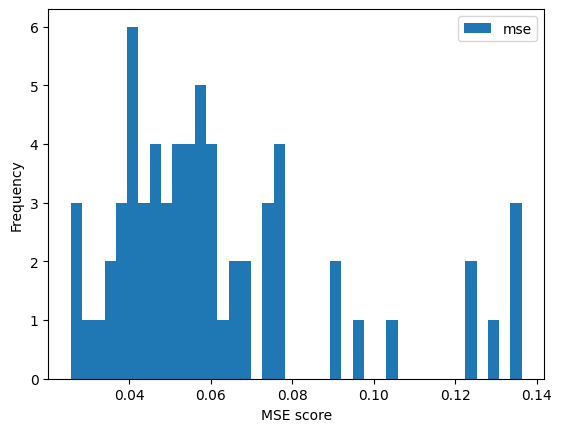

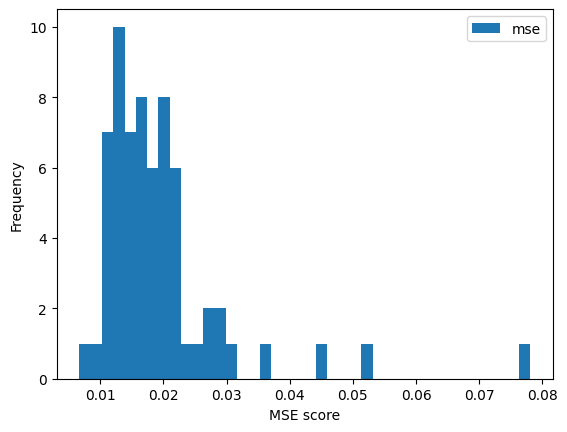

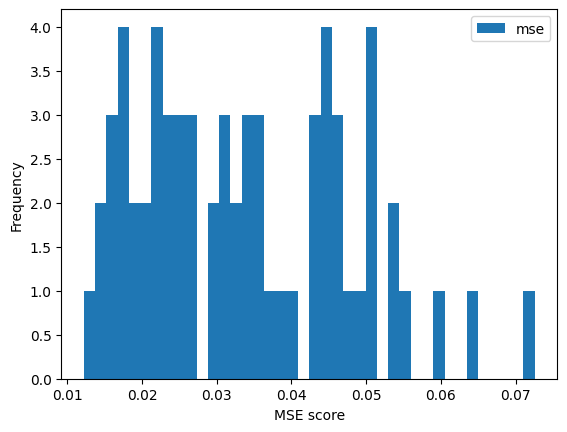

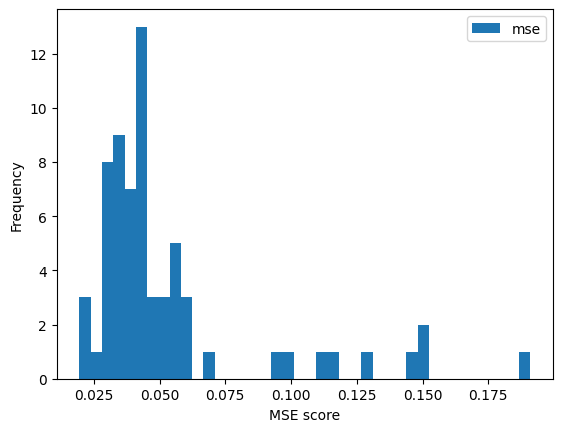

In [56]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

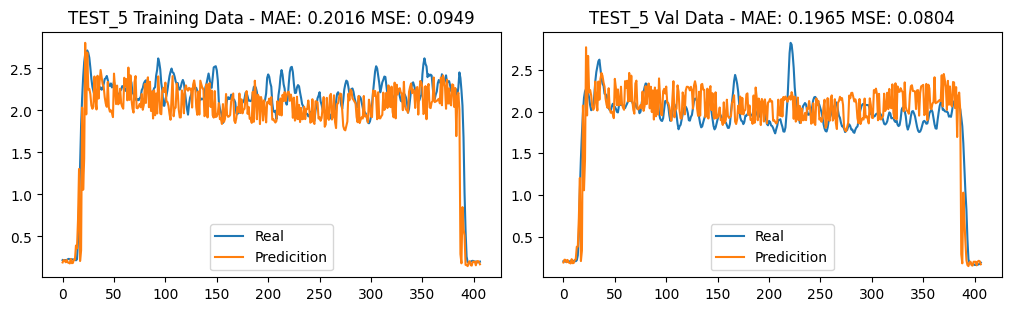

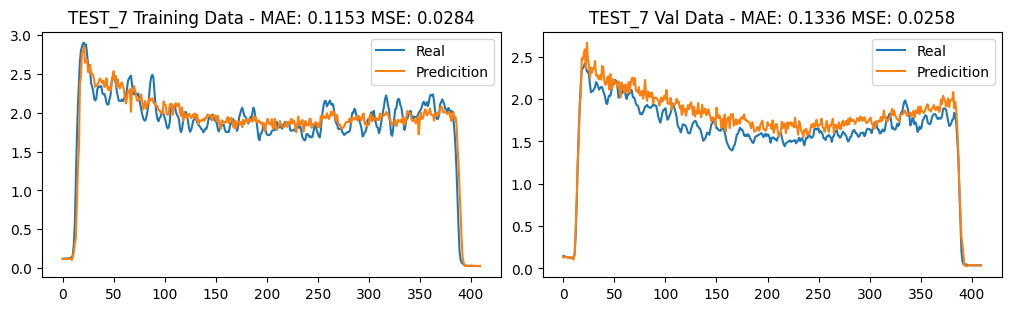

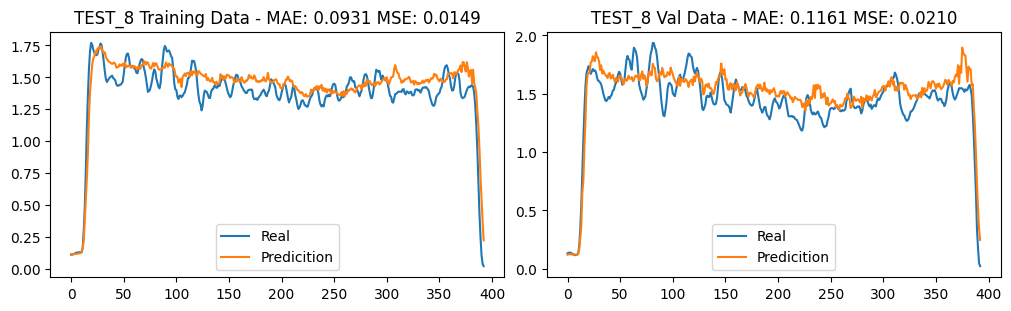

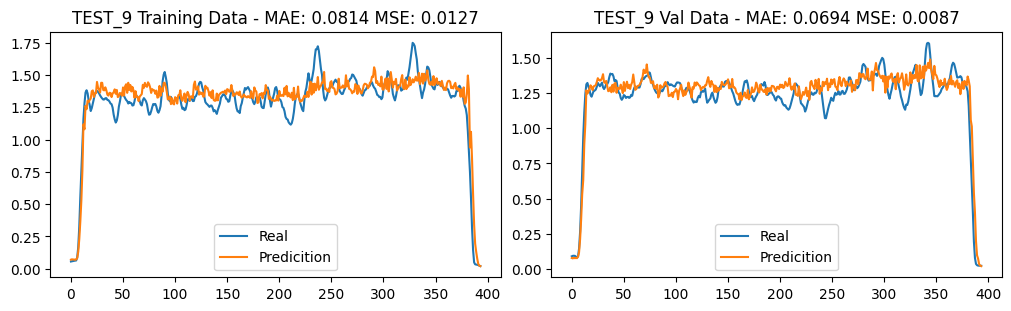

In [57]:
for test in exps:
    fig, ax = plt.subplots(1, 2, figsize=(10,3), constrained_layout=True)
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'{autoe[test].RMS.exp_name} Training Data - {ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'{autoe[test].RMS.exp_name} Val Data - {ax[1].get_title()}')

## Thresholds for anomaly detection of each model

In [58]:
for test in exps:
    autoe[test].thres


Cutoffs:
	MAE cutoff: 0.23308
	MSE cutoff: 0.08916
	R2 cutoff: -0.58957

Cutoffs:
	MAE cutoff: 0.12887
	MSE cutoff: 0.03002
	R2 cutoff: -0.17328

Cutoffs:
	MAE cutoff: 0.16506
	MSE cutoff: 0.04765
	R2 cutoff: -0.06823

Cutoffs:
	MAE cutoff: 0.22679
	MSE cutoff: 0.08841
	R2 cutoff: -1.13886


## Show scores against threshold

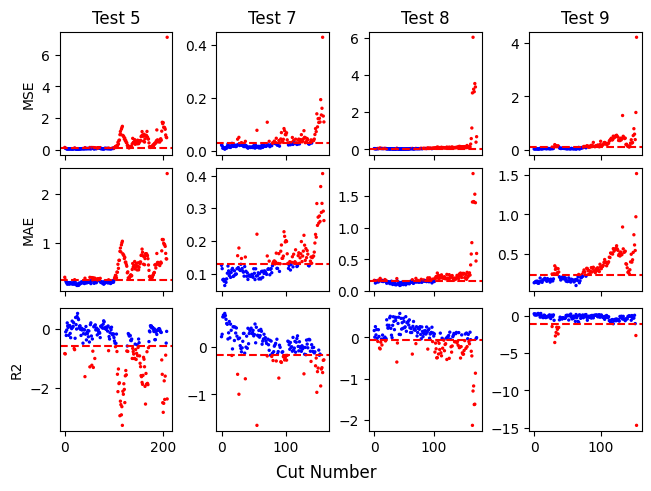

In [98]:
metrics = ['mse', 'mae', 'r2']

fig, ax = plt.subplots(len(metrics), len(exps),
                    #    figsize=(15, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        axes[(i)].set_title(test)
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

In [60]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 Test 5
              mae         mse          r2
count  209.000000  209.000000  209.000000
mean     0.403186    0.379388   -0.577714
std      0.282253    0.609222    0.814285
min      0.125231    0.025715   -3.253763
25%      0.190132    0.059999   -0.956192
50%      0.281462    0.136251   -0.217462
75%      0.573873    0.554782    0.005650
max      2.406755    7.109000    0.525586

 Test 7
              mae         mse          r2
count  160.000000  160.000000  160.000000
mean     0.140368    0.039308    0.027555
std      0.057302    0.044118    0.330539
min      0.063867    0.006689   -1.654626
25%      0.102455    0.018139   -0.125099
50%      0.124716    0.026906    0.046539
75%      0.155053    0.042078    0.230483
max      0.406322    0.429475    0.710350

 Test 8
              mae         mse          r2
count  173.000000  173.000000  173.000000
mean     0.234133    0.207507   -0.019059
std      0.256875    0.702834    0.376131
min      0.086957    0.012208   -2.124050
25%    

## autoe models latent space

In [61]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

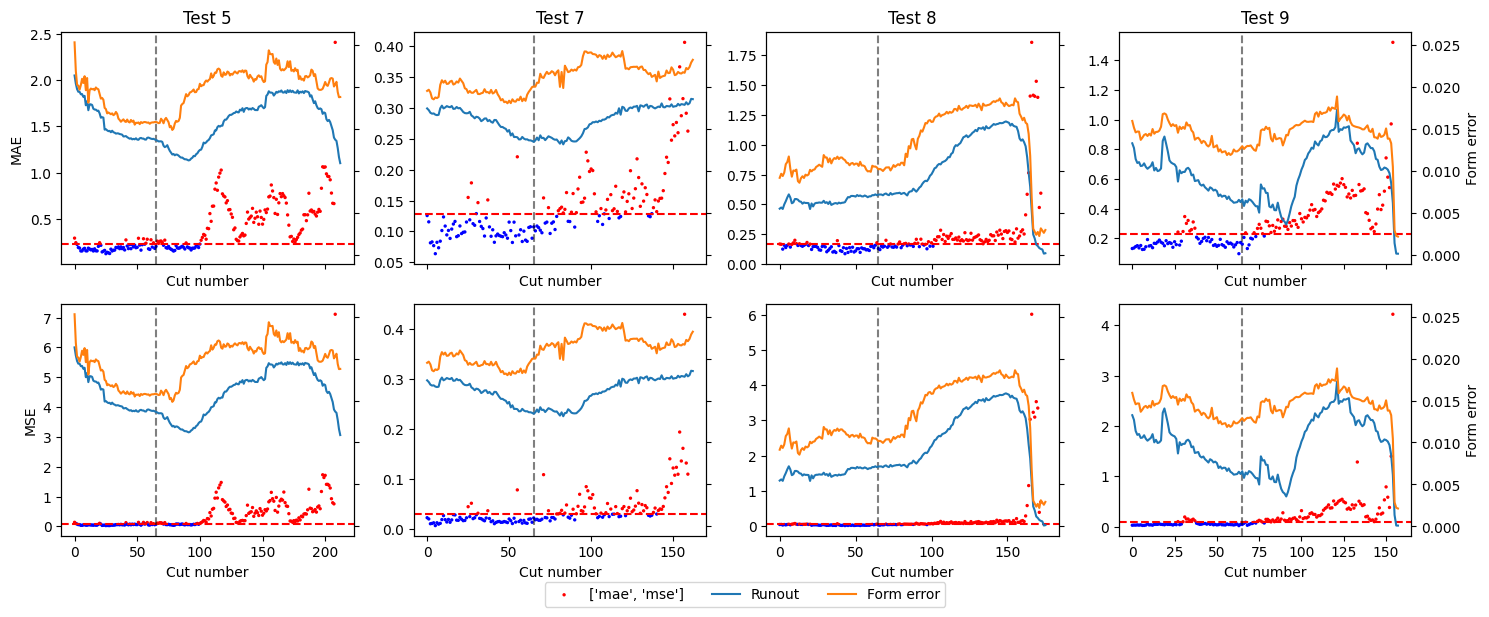

In [102]:
features = ['Runout', 'Form error']
metric = ['mae', 'mse']


fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(15, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )

ax2 = []
for a in ax.ravel():
    ax2.append(a.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(exps):
    axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature]
            axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)

        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel(f'{feature}')


for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              [metric] + lab2, 
              loc='center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()